<a href="https://www.kaggle.com/code/masoudnaghshbandi/gluotnts-interval-prediction?scriptVersionId=109726100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [73]:
#pip install yfinance

In [74]:
#pip install tensorflow

## Import libraries

In [75]:
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction 
from gluonts.mx.trainer.model_averaging import ModelAveraging , SelectNBestMean
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions

## Load Data

In [76]:
ms=yf.download('MSFT',
           start='2012-01-01',
           end='2021-12-31',
           progress=False)
df=ms[['Adj Close','Open','Close','High','Low']].round(3)
df

,Adj Close,Open,Close,High,Low
Date,,,,,
2012-01-03,21.527,26.55,26.77,26.96,26.39
2012-01-04,22.034,26.82,27.40,27.47,26.78
2012-01-05,22.259,27.38,27.68,27.73,27.29
2012-01-06,22.605,27.53,28.11,28.19,27.53
2012-01-09,22.307,28.05,27.74,28.10,27.72
...,...,...,...,...,...
2021-12-23,332.517,332.75,334.69,336.39,332.73
2021-12-27,340.227,335.46,342.45,342.48,335.43
2021-12-28,339.035,343.15,341.25,343.81,340.32


<AxesSubplot:xlabel='Date'>

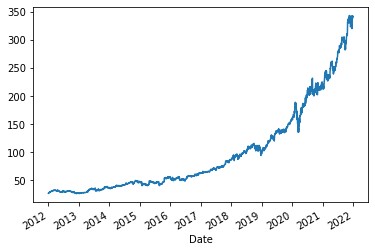

In [77]:
df.Close.plot()

In [78]:
df[:'2020'].Close.values.reshape(-1,1)

array([[ 26.77],
       [ 27.4 ],
       [ 27.68],
       ...,
       [224.15],
       [221.68],
       [222.42]])

## Creat train dataset

In [79]:
train_data=ListDataset([{'start':df.index[0],'target':df.Close[:'2020']}],
                      freq='D')

In [80]:
train_listData=next(iter(train_data))
train_series=to_pandas(train_listData)

<AxesSubplot:>

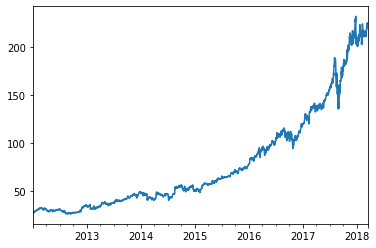

In [81]:
train_series.plot()

# Creat test data set

In [82]:
test_data=ListDataset([{'start':df.index[0],'target':df.Close}],
                      freq='D')

In [83]:
test_listData=next(iter(test_data))
test_series=to_pandas(test_listData)

<AxesSubplot:>

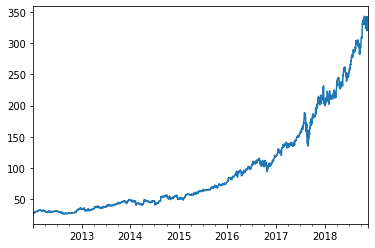

In [84]:
test_series.plot()

# define some params to model

In [85]:
callbacks=[LearningRateReduction(objective='min',
                                patience=10,
                                base_lr=1e-3,
                                decay_factor=0.5),
         ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))]

# Define models

In [86]:
deepAR_model=DeepAREstimator(
freq='D',
prediction_length=5,
context_length=10,
num_layers=4,
num_cells=100,
dropout_rate=0.5,
trainer=Trainer(epochs=10,callbacks=callbacks))

In [87]:
deepAR_model_predictator=deepAR_model.train(train_data)

100%|██████████| 50/50 [00:07<00:00,  7.09it/s, epoch=10/10, avg_epoch_loss=1.89]


# Predict model

In [88]:
forecast_it,ts_it=make_evaluation_predictions(dataset=test_data,
                                             predictor=deepAR_model_predictator,
                                             num_samples=100)

In [89]:
forecasts=list(forecast_it)
tss=list(ts_it)

In [90]:
ts_entry=tss[0]

In [91]:
forecast_entry = forecasts[0]

In [92]:
forecast_entry.mean

array([337.81555, 338.10474, 336.0167 , 336.75543, 338.2707 ],
      dtype=float32)

In [93]:
forecast_entry.quantile(0.5)

array([336.62085, 336.2893 , 336.62903, 338.40338, 337.27097],
      dtype=float32)

In [94]:
np.array(ts_entry[:5]).reshape(
    -1,
)

array([26.77, 27.4 , 27.68, 28.11, 27.74], dtype=float32)

In [95]:
forecast_entry.mean

array([337.81555, 338.10474, 336.0167 , 336.75543, 338.2707 ],
      dtype=float32)

# Plot prediction in define interval

In [96]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 5
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")


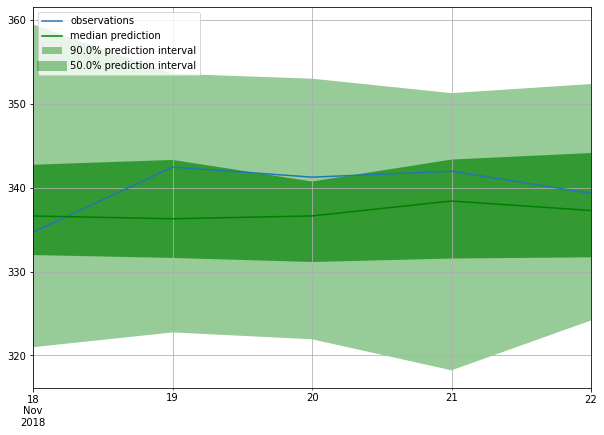

In [97]:
plot_prob_forecasts(ts_entry, forecast_entry)
